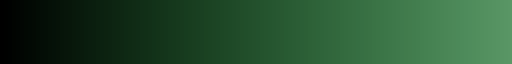

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import geopandas as gpd
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.5, reverse=True, as_cmap=True)
# from mpl_toolkits.basemap import Basemap

In [2]:
hhct = pd.read_csv('../../data/Heat_Health_Census_Tracts.csv')
awater = gpd.read_file("../../data/external_data/tl_2020_36_tract10/tl_2020_36_tract10.shp")
urban_tree_canopy = pd.read_csv('../../clean_data/greenspace_data/urban_tree_canopy.csv')
urban_tree_canopy['GEOID'] = urban_tree_canopy['census_block'].astype(str).str[:11]
counties = ['36005', '36047', '36061', '36081', '36085']
mask = urban_tree_canopy.GEOID.str[:5].isin(counties)
urban_tree_nyc = urban_tree_canopy[mask]
cols1 = ['mean_percent_tree_cover', 'tree_gap', 'surface_temp', 'income_percent']
cols2 = ['income_group', 'pop_dens_group']
urban_tree_nyc = urban_tree_nyc[cols1 + cols2 + ['GEOID']]
dct = {}
for col in cols1:
    dct[col] = 'mean'
for col in cols2:
    dct[col] = 'mean'
urban_tree_nyc = urban_tree_nyc.groupby('GEOID').agg({**dct}).reset_index()
urban_tree_nyc['GEOID'] = urban_tree_nyc['GEOID'].map(int)


In [3]:
hhct['county_fip'] = hhct['GEOID'].map(lambda x: str(x)[:5])
mask = hhct.county_fip.isin(counties)
hhct = hhct[mask]
mask = awater.GEOID10.str[:5].isin(counties)
awater = awater[mask]

In [4]:
# take important columns
awater_df = awater[['GEOID10', 'ALAND10', 'AWATER10', 'geometry']]
awater_df['GEOID10'] = awater_df['GEOID10'].map(int)
hhct_df = hhct[['GEOID', 'High_Summer_Mean_LST_F', 'Summer_Mean_LST_F', 'MEAN_PCT_ImperviousSurfaces']]
awater_df = pd.merge(hhct_df, awater_df, left_on='GEOID', right_on='GEOID10', how='left')
del awater_df['GEOID10']

dc_GEOID_surfact_temp = dict(zip(urban_tree_nyc.GEOID, urban_tree_nyc.surface_temp))
awater_df['surface_temp'] = awater_df.GEOID.map(dc_GEOID_surfact_temp) 
mt = awater_df['surface_temp'].mean()
awater_df['surface_temp'].fillna(mt, inplace=True)


dc_GEOID_mean_cover = dict(zip(urban_tree_nyc.GEOID, urban_tree_nyc.mean_percent_tree_cover))
awater_df['mean_percent_tree_cover'] = awater_df.GEOID.map(dc_GEOID_mean_cover) 
mt = awater_df['mean_percent_tree_cover'].mean()
awater_df['mean_percent_tree_cover'].fillna(mt, inplace=True)



awater_df['High_Summer_Mean_LST_C'] = awater_df.High_Summer_Mean_LST_F.map(lambda x: (x-32)*5/9)
awater_df['Summer_Mean_LST_C'] = awater_df.Summer_Mean_LST_F.map(lambda x: (x-32)*5/9)

awater_df['diff1'] = awater_df['High_Summer_Mean_LST_C'] - awater_df['surface_temp']
awater_df['diff2'] = awater_df['Summer_Mean_LST_C'] - awater_df['surface_temp']


/Users/arnhavdatar/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [5]:
awater_df[['High_Summer_Mean_LST_F', 'Summer_Mean_LST_F']]

,High_Summer_Mean_LST_F,Summer_Mean_LST_F
0,83.243164,83.243164
1,96.719470,96.719470
2,96.964211,96.964211
3,98.472110,98.472110
4,95.803680,95.803680
...,...,...
2159,97.516850,97.516850
2160,97.516846,97.516846
2161,93.269470,93.269470
2162,88.027367,88.027367


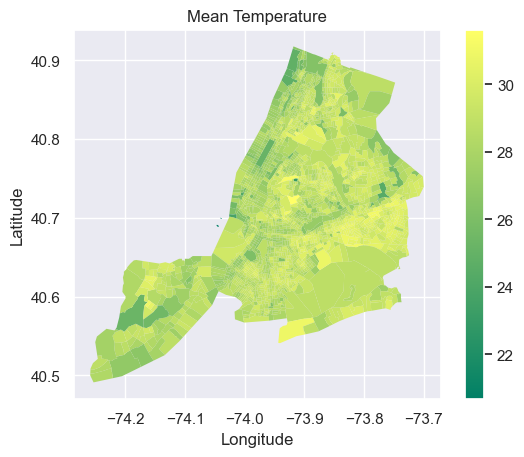

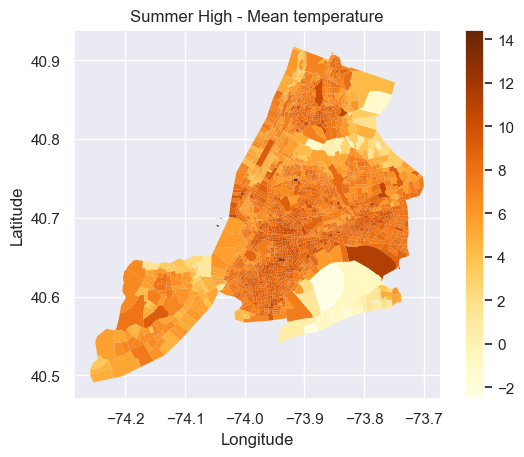

In [7]:

awater_df = gpd.GeoDataFrame(awater_df, geometry='geometry')
awater_df.plot(column='surface_temp', cmap='summer', legend=True, edgecolor = 'none')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Mean Temperature")
plt.savefig('./temp_plots/temp.png', bbox_inches='tight')

awater_df.plot(column='diff1', cmap='YlOrBr', legend=True, edgecolor = 'none')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Summer High - Mean temperature")
plt.savefig('./temp_plots/temp_diff.png', bbox_inches='tight')

plt.show()

<AxesSubplot:>

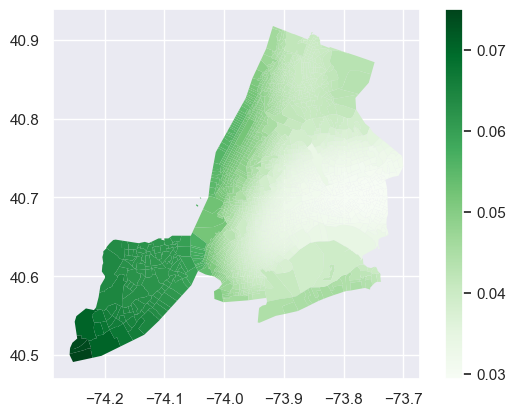

In [8]:
merged = awater_df
# calculate percentage of water
awater_df['water_percentage'] = awater_df['AWATER10']/(awater_df['ALAND10'] + awater_df['AWATER10'])
awater_df['latitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.x,
    axis=1
)
awater_df['longitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.y,
    axis=1
)

def app(row):
    lat_diff = (merged['latitude'] - row.latitude) * 0.652
    long_diff = (merged['longitude'] - row.longitude) * 0.546
    distance = lat_diff**2 + long_diff**2
    exp_dist = np.exp(-np.sqrt(distance) * 10)
    weighted_exp_dist = exp_dist * merged['mean_percent_tree_cover'] 
    return weighted_exp_dist.sum() / exp_dist.sum()

merged['green_gaussian'] = merged.apply(
    lambda row: app(row),
    axis=1
)


def app(row):
    lat_diff = (merged['latitude'] - row.latitude) 
    long_diff = (merged['longitude'] - row.longitude)
    distance = lat_diff**2 + long_diff**2
    exp_dist = np.exp(- np.sqrt(distance) * 10 ) 
    weighted_exp_dist = exp_dist * merged['water_percentage'] 
    return weighted_exp_dist.sum() / exp_dist.sum()

merged['water_gaussian'] = merged.apply(
    lambda row: app(row),
    axis=1
)

awater_df.plot(column='water_gaussian', cmap='Greens', legend=True, edgecolor = 'none')


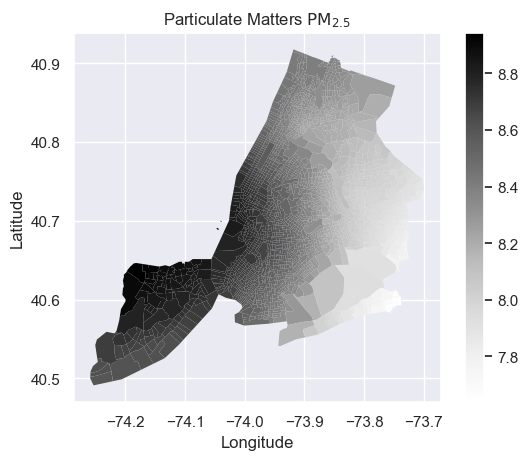

In [11]:
aqi = pd.read_csv('../../data/aqi.csv')
sns.set_theme(style="darkgrid")

aqi_ny_state = aqi[aqi['statefips'] == 36]
aqi_ny_state_agg = pd.DataFrame(aqi_ny_state.groupby(['ctfips']).mean()[['DS_PM_pred', 'DS_PM_stdd']]).reset_index()
dc_fip_to_DS = dict(zip(aqi_ny_state_agg.ctfips, aqi_ny_state_agg.DS_PM_pred))
awater_df['air_impurity'] = awater_df['GEOID'].map(dc_fip_to_DS)
awater_df.plot(column='air_impurity', cmap='Greys', legend=True, edgecolor = 'none')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r"Particulate Matters $\operatorname{PM}_{2.5}$")
plt.savefig("aqi")
plt.show()


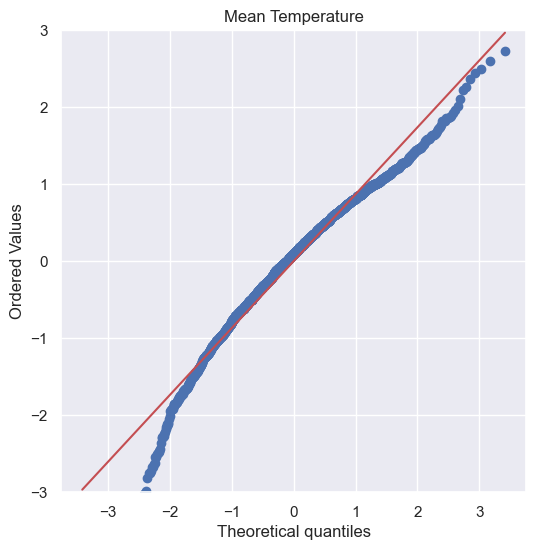

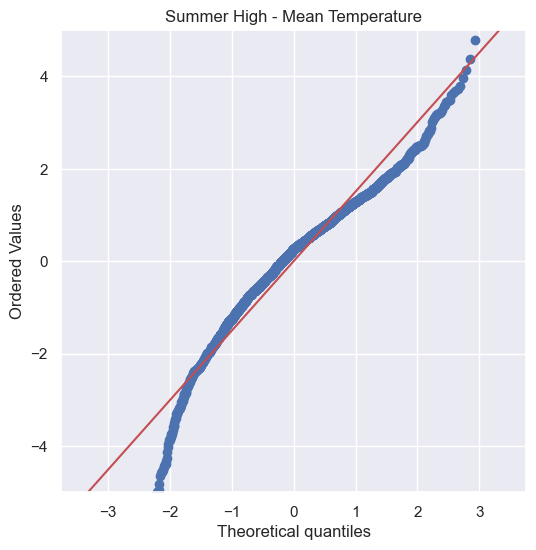

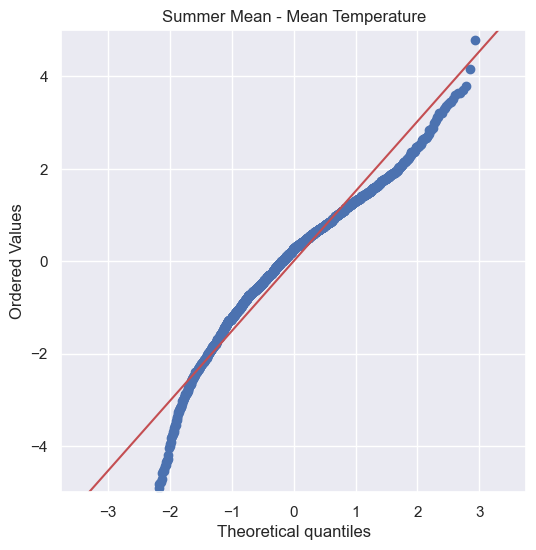

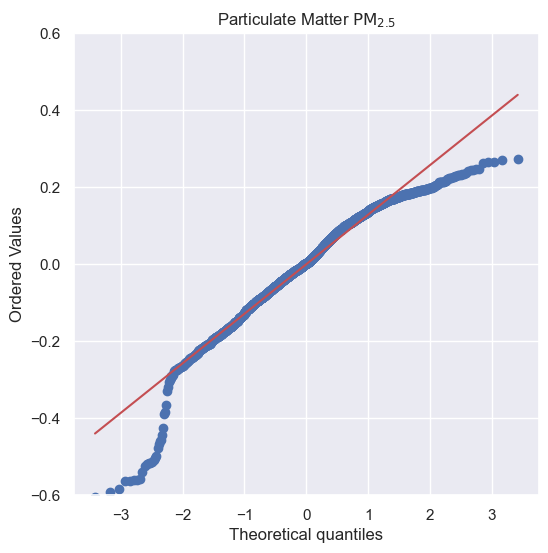

In [12]:
# do regression using statsmodels
import statsmodels.regression.linear_model as sm
from scipy import stats
import scipy
sns.set_theme(style="darkgrid")


formula = 'surface_temp ~ water_gaussian * green_gaussian'
reg = sm.OLS.from_formula(formula, data=awater_df).fit()
fig, ax=plt.subplots(figsize=(6,6))
stats.probplot(reg.resid, dist="norm", plot=plt)
ax.set_ylim(-3, 3)
plt.title(r"Mean Temperature")
plt.savefig('./qq/temp.png', bbox_inches='tight')
plt.show()

formula = 'diff1 ~ water_gaussian * green_gaussian'
reg = sm.OLS.from_formula(formula, data=awater_df).fit()
fig, ax=plt.subplots(figsize=(6,6))
stats.probplot(reg.resid, dist="norm", plot=plt)
ax.set_ylim(-5, 5)
plt.title(r"Summer High - Mean Temperature")
plt.savefig('./qq/diff1.png')
plt.show()

formula = 'diff2 ~ water_gaussian * green_gaussian'
reg = sm.OLS.from_formula(formula, data=awater_df).fit()
fig, ax=plt.subplots(figsize=(6,6))
stats.probplot(reg.resid, dist="norm", plot=plt)
ax.set_ylim(-5, 5)
plt.title(r"Summer Mean - Mean Temperature")
plt.savefig('./qq/diff2.png')
plt.show()


formula = 'air_impurity ~ water_gaussian * green_gaussian'
reg = sm.OLS.from_formula(formula, data=awater_df).fit()
fig, ax=plt.subplots(figsize=(6,6))
stats.probplot(reg.resid, dist="norm", plot=plt)
ax.set_ylim(-0.6, 0.6)
plt.title(r"Particulate Matter $\operatorname{PM}_{2.5}$")
plt.savefig('./qq/air_impurity.png')
plt.show()


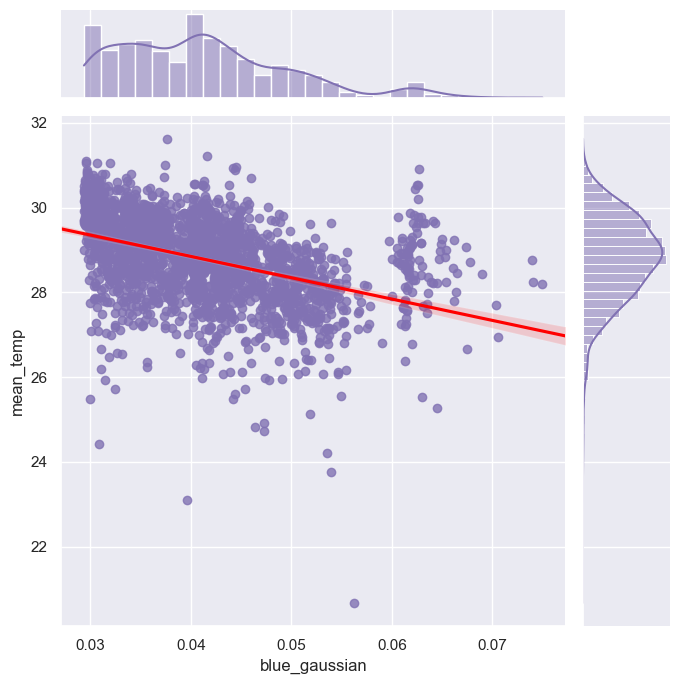

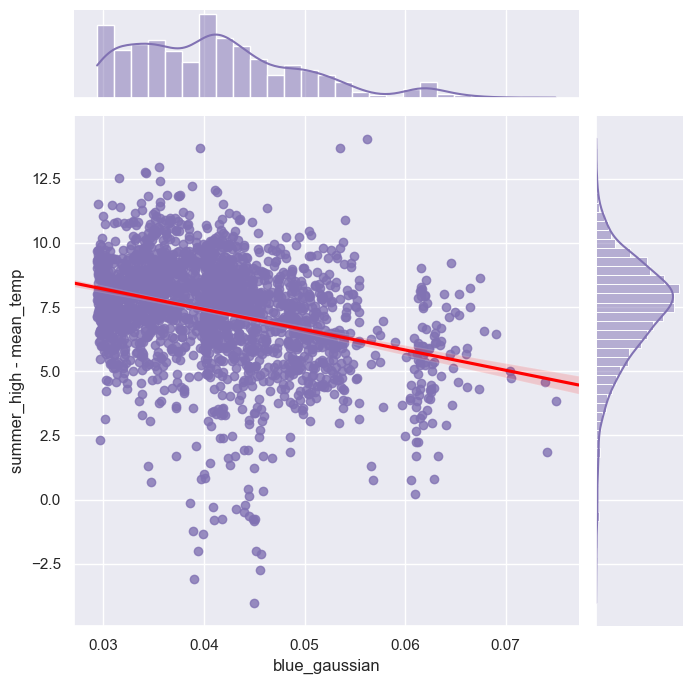

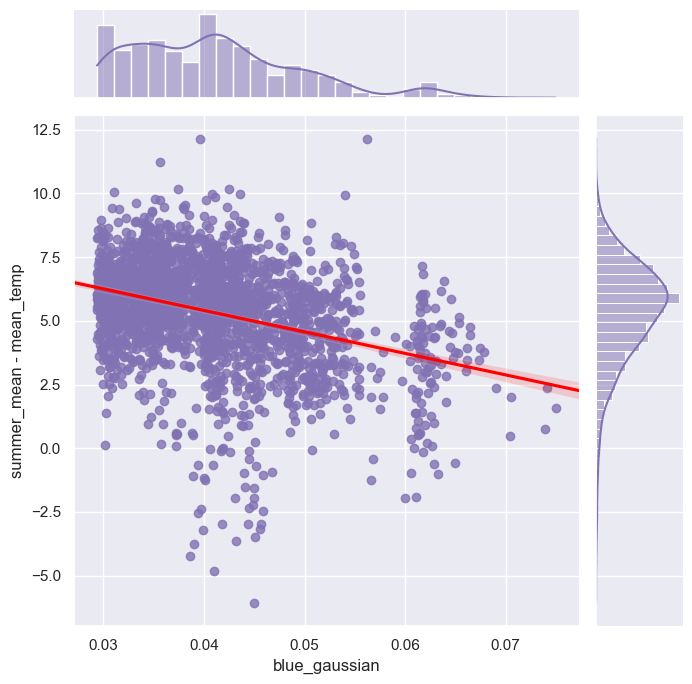

In [18]:
tdf = awater_df[['surface_temp', 'diff1', 'diff2', 'water_gaussian', 'green_gaussian']]
tdf = tdf.rename(columns = {'surface_temp': 'mean_temp', 'diff1': 'summer_high - mean_temp', 'diff2': 'summer_mean - mean_temp', 'water_gaussian': 'blue_gaussian'})



sns.set_theme(style="darkgrid")
g = sns.jointplot(x="blue_gaussian", y="mean_temp", data=tdf, kind="reg", truncate=False, color="m", height=7,  joint_kws={'line_kws':{'color':'red'}}) 
plt.savefig("./temp_plots/temp_vs_blue.png")
sns.set_theme(style="darkgrid")
g = sns.jointplot(x="blue_gaussian", y="summer_high - mean_temp", data=tdf, kind="reg", truncate=False, color="m", height=7,  joint_kws={'line_kws':{'color':'red'}}) 
plt.savefig("./temp_plots/summer_high_vs_blue.png")
sns.set_theme(style="darkgrid")
g = sns.jointplot(x="blue_gaussian", y="summer_mean - mean_temp", data=tdf, kind="reg", truncate=False, color="m", height=7,  joint_kws={'line_kws':{'color':'red'}}) 
plt.savefig("./temp_plots/summer_mean_vs_blue.png")





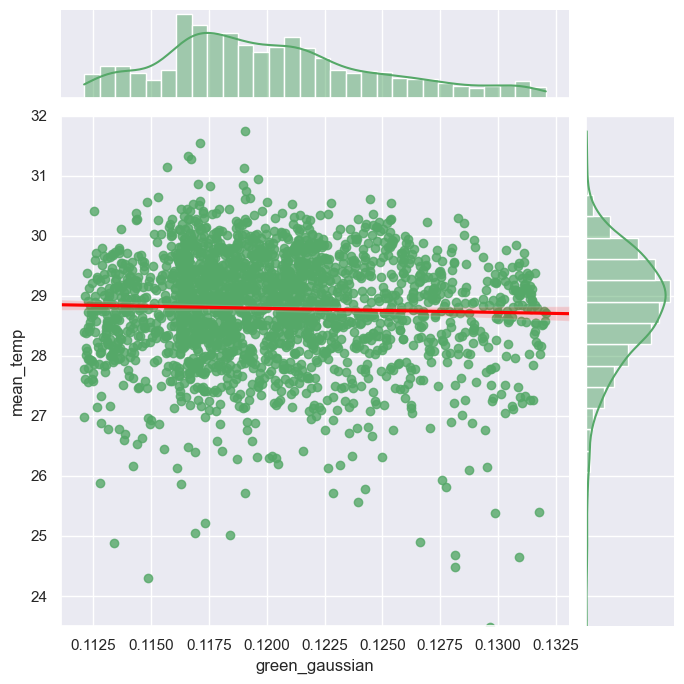

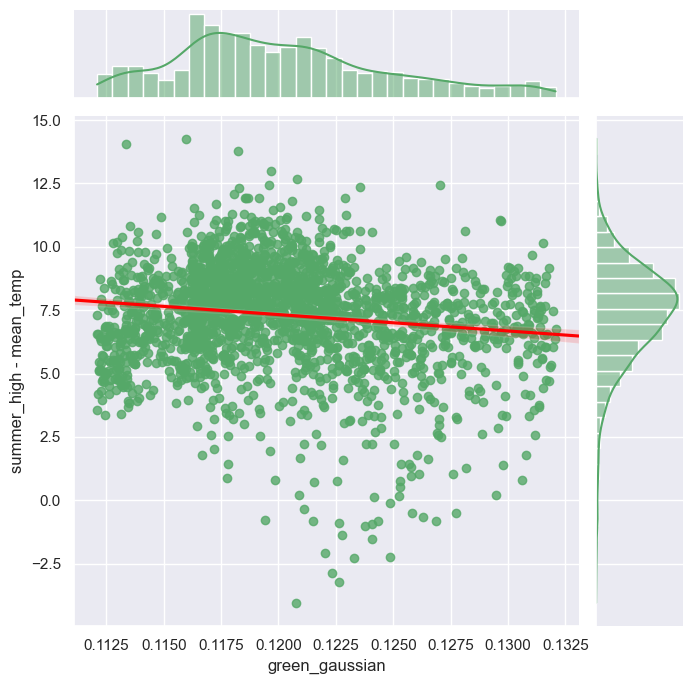

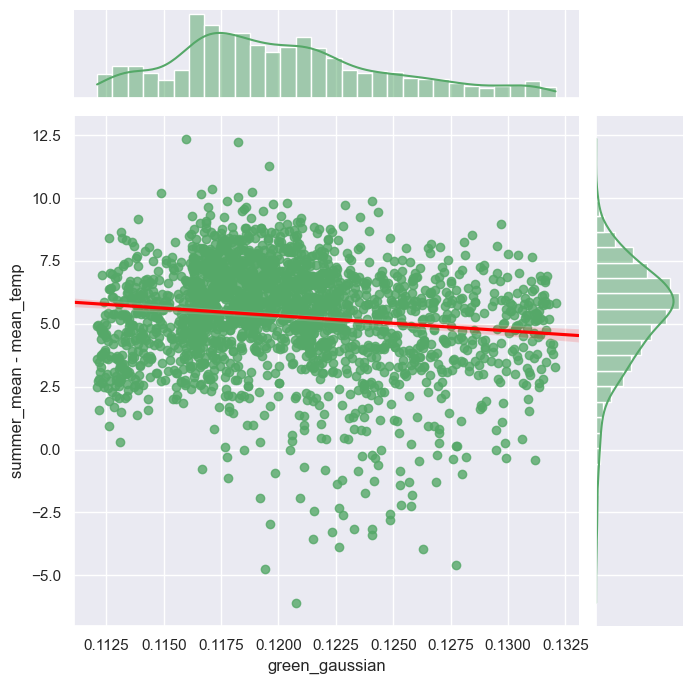

In [24]:
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="green_gaussian", y="mean_temp", data=tdf, kind="reg", truncate=False, color="g", height=7,  joint_kws={'line_kws':{'color':'red'}}, ylim=(23.5, 32), marginal_kws=dict(bins=30)) 
plt.savefig("./temp_plots/temp_vs_green.png")
plt.show()
g = sns.jointplot(x="green_gaussian", y="summer_high - mean_temp", data=tdf, kind="reg", truncate=False, color="g", height=7,  joint_kws={'line_kws':{'color':'red'}}, marginal_kws=dict(bins=30)) 
plt.savefig("./temp_plots/summer_high_vs_green.png")
plt.show()
g = sns.jointplot(x="green_gaussian", y="summer_mean - mean_temp", data=tdf, kind="reg", truncate=False, color="g", height=7,  joint_kws={'line_kws':{'color':'red'}}, marginal_kws=dict(bins=30)) 
plt.savefig("./temp_plots/summer_mean_vs_green.png")
plt.show()


In [25]:
# do regression using statsmodels
import statsmodels.regression.linear_model as sm
formula = 'air_impurity ~ water_gaussian * green_gaussian'
reg = sm.OLS.from_formula(formula, data=awater_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           air_impurity   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     2059.
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:05:21   Log-Likelihood:                 1324.3
No. Observations:                2164   AIC:                            -2641.
Df Residuals:                    2160   BIC:                            -2618.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## Making plots with temperature

Specifically corresponding to the clusters. 

In [28]:
!unzip class.zip

Archive:  class.zip
   creating: class/
  inflating: class/low_tree_low_water_2.csv  
  inflating: __MACOSX/class/._low_tree_low_water_2.csv  
  inflating: class/high_tree_high_water.csv  
  inflating: __MACOSX/class/._high_tree_high_water.csv  
  inflating: class/low_tree_high_water.csv  
  inflating: __MACOSX/class/._low_tree_high_water.csv  
  inflating: class/high_tree_low_water_2.csv  
  inflating: __MACOSX/class/._high_tree_low_water_2.csv  
  inflating: class/high_tree_high_water_2.csv  
  inflating: __MACOSX/class/._high_tree_high_water_2.csv  
  inflating: class/high_tree_low_water.csv  
  inflating: __MACOSX/class/._high_tree_low_water.csv  
  inflating: class/low_tree_high_water_2.csv  
  inflating: __MACOSX/class/._low_tree_high_water_2.csv  
  inflating: class/low_tree_low_water.csv  
  inflating: __MACOSX/class/._low_tree_low_water.csv  


In [29]:
sett = ['low', 'high']
dc_geoid_to_cluster = {}
dc_geoid_to_cluster2 = {}
dc_label_to_int = {}
cn = 0
for x in sett:
    for y in sett:
        fl = './class/'+x+"_tree_"+y+"_water.csv"
        fl2 = './class/'+x+"_tree_"+y+"_water_2.csv"

        df = pd.read_csv(fl)
        for geoid in (df.columns):
            dc_geoid_to_cluster[int(geoid)] = x+"_tree_"+y+"_water"

        df = pd.read_csv(fl2)
        for geoid in (df.columns):
            dc_geoid_to_cluster2[int(geoid)] = x+"_tree_"+y+"_water"

        dc_label_to_int[x+"_tree_"+y+"_water"] = cn
        cn += 1

dc_geoid_to_cluster


{36085027900: 'low_tree_low_water',
 36085029102: 'low_tree_low_water',
 36047063600: 'low_tree_low_water',
 36047063800: 'low_tree_low_water',
 36047064000: 'low_tree_low_water',
 36047064200: 'low_tree_low_water',
 36047064400: 'low_tree_low_water',
 36047064600: 'low_tree_low_water',
 36047064800: 'low_tree_low_water',
 36047065000: 'low_tree_low_water',
 36047065400: 'low_tree_low_water',
 36047065600: 'low_tree_low_water',
 36047065800: 'low_tree_low_water',
 36047066000: 'low_tree_low_water',
 36047066200: 'low_tree_low_water',
 36047067000: 'low_tree_low_water',
 36047042300: 'low_tree_low_water',
 36047042500: 'low_tree_low_water',
 36047042700: 'low_tree_low_water',
 36047042900: 'low_tree_low_water',
 36047077400: 'low_tree_low_water',
 36047077600: 'low_tree_low_water',
 36047078000: 'low_tree_low_water',
 36047078200: 'low_tree_low_water',
 36047078400: 'low_tree_low_water',
 36047078600: 'low_tree_low_water',
 36047078800: 'low_tree_low_water',
 36047079000: 'low_tree_low_

In [30]:
awater_df['cluster1'] = awater_df['GEOID'].map(dc_geoid_to_cluster)
awater_df['cluster1_int'] = awater_df['cluster1'].map(dc_label_to_int)
awater_df['cluster2'] = awater_df.GEOID.map(dc_geoid_to_cluster2)
awater_df['cluster2_int'] = awater_df['cluster2'].map(dc_label_to_int)

awater_df.isnull().sum() / len(awater_df)
print(dc_label_to_int)

{'low_tree_low_water': 0, 'low_tree_high_water': 1, 'high_tree_low_water': 2, 'high_tree_high_water': 3}


29.234761554397153 28.73387961734339 28.299726963316626 28.30624973579697


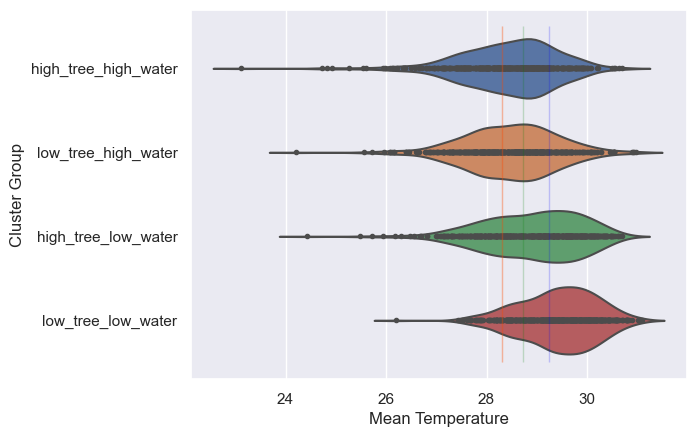

In [31]:

def violinplotstuff(xval, xname):
    sns.violinplot(data=awater_df, x = xval, y = 'cluster2', inner="points", orient="h")
    def get_mean(num):
        return awater_df[awater_df['cluster1_int'] == num][xval].mean()
    print(get_mean(0), get_mean(1), get_mean(2), get_mean(3))
    sns.lineplot(x=[get_mean(0), get_mean(0)], y=[-0.5, 3.5], color='blue', linestyle='--', lw = 1000)
    sns.lineplot(x=[get_mean(2), get_mean(2)], y=[-0.5, 3.5], color='orange', linestyle='--')
    sns.lineplot(x=[get_mean(1), get_mean(1)], y=[-0.5, 3.5], color='green', linestyle='--')
    sns.lineplot(x=[get_mean(3), get_mean(3)], y=[-0.5, 3.5], color='Red', linestyle='--')
    plt.xlabel(xname)
    plt.ylabel('Cluster Group')
    plt.savefig('./temp_plots/violin_'+xval)
    plt.show()

violinplotstuff('surface_temp', "Mean Temperature")

In [32]:
dc_blah = {'high_tree_high_water': 0, 'low_tree_high_water': 1, 'high_tree_low_water': 2, 'low_tree_low_water': 3}
awater_df['idcluster1'] = awater_df['cluster1'].map(dc_blah)
awater_df['idcluster2'] = awater_df['cluster2'].map(dc_blah)
import copy
save_copy = copy.deepcopy(awater_df)


8.359 &  8.391 &  8.367 &  8.43 &  


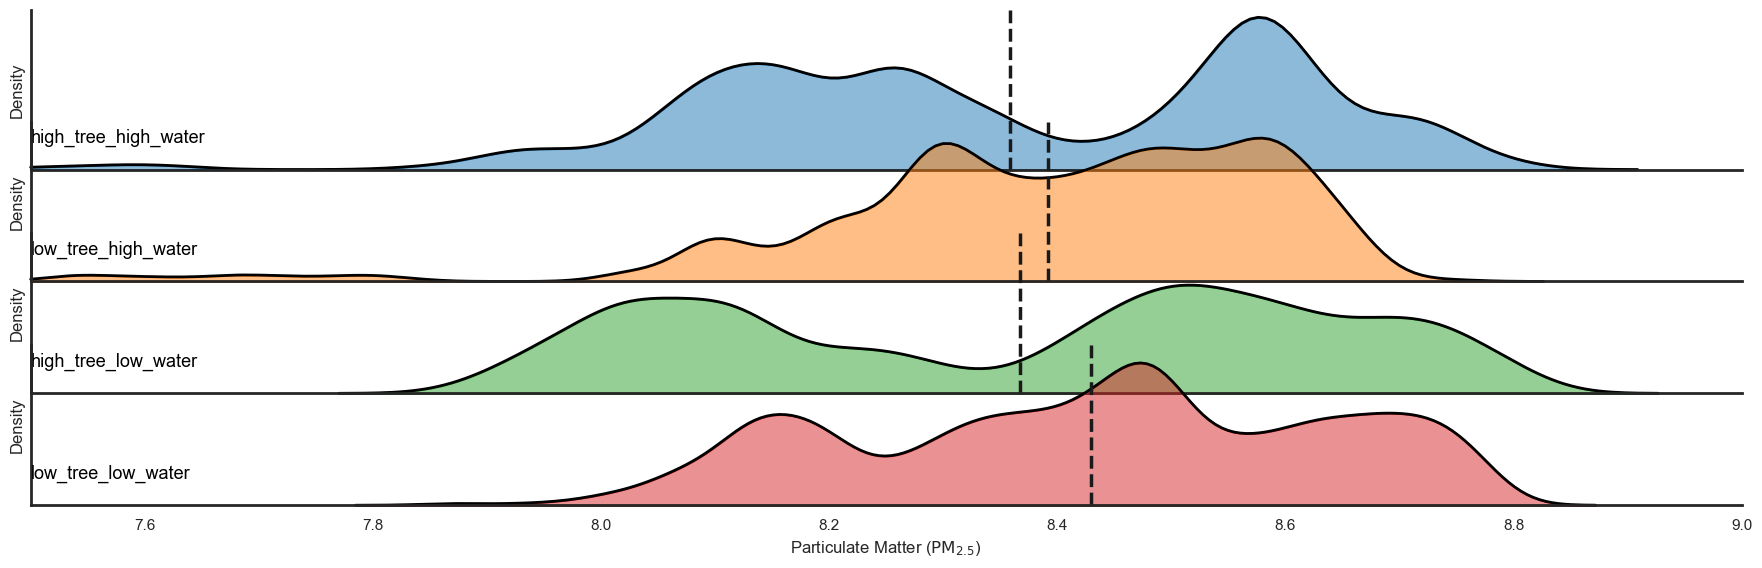

In [34]:
cluster_id = 'cluster2'
awater_df.sort_values(by='id' + cluster_id, inplace=True)


temp_id = 'surface_temp'
temp_id = 'diff1'
temp_id = 'diff2'
temp_id = 'air_impurity'

xlab = r"Mean_Temperature"
xlab = r"Summer_High - Mean_Temperature"
xlab = r"Summer_Mean - Mean_Temperature"
xlab = r"Particulate Matter ($\operatorname{PM}_{2.5}$)"

limits = (1, 11)
limits = (26, 31.5)
limits = (0, 11)
limits = (7.5, 9)



sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("tab10", 12)
f = sns.FacetGrid(awater_df, row=cluster_id, hue=cluster_id, aspect=12, height=1.5, palette=palette)
axes = f.axes
axes[0,0].set_xlim(limits)
axes[1,0].set_xlim(limits)
axes[2,0].set_xlim(limits)
axes[3,0].set_xlim(limits)
# Draw the densities in a few steps

f.map(sns.kdeplot, temp_id,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=0.5, linewidth=1.5, clip = limits )
f.map(sns.kdeplot, temp_id, clip_on=False, color="black", lw=2, bw_adjust=.5, clip = limits)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13, ha="left", va="center", transform=ax.transAxes)

f.map(label, cluster_id)

cn = 0

def specs(x, **kwargs):
    print(str(round(x.mean(), 3)) + ' & ', end = " ")
    plt.axvline(x.mean(), c='k', lw=2.5, ls='--')

f.map(specs,temp_id)
print("")
f.set_titles("")
f.fig.subplots_adjust(hspace=-.3)
f.set(yticks=[], xlabel=xlab)

plt.savefig("./temp_plots/ridge_"+temp_id+".png")
plt.show()



In [35]:
from tqdm import tqdm
tqdm.pandas()

In [36]:
merged = awater_df

def app(row, lats, longs, points, df):
    
    # Getting distances
    lat_diff = (lats - row.latitude) * 0.652
    long_diff = (longs - row.longitude) * 0.546
    distances = lat_diff**2 + long_diff**2
    
    # Getting col of top minima_lim distances
    idx = np.argpartition(distances, points)
    ls1 = []
    for i in idx[:points]:
        ls1.append(df.iloc[i]['GEOID'])
    
    return ls1
    
        
def get_closest_geoids(
    df: pd.DataFrame,
    points: int = 10,
):
    lats = df['latitude']
    longs = df['longitude']
    geoids = df['GEOID']

    df['nearest_points'] = df.progress_apply(
        lambda row: app(row, lats, longs, points, df),
        axis=1
    )
    return dict(zip(df.GEOID, df.nearest_points))


dc_geoid_to_closest_geoids = get_closest_geoids(merged, 40)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2164/2164 [00:05<00:00, 414.52it/s]


In [37]:
dc_geo_to_aqi = dict(zip(merged.GEOID, merged.air_impurity))
dc_geo_to_temp = dict(zip(merged.GEOID, merged.surface_temp))
dc_geo_to_diff = dict(zip(merged.GEOID, merged.diff1))

def app(row, dc):
    ls = [dc[x] for x in row.nearest_points]
    ls.sort()
    return ls[2]

merged['minima_aqi'] = merged.progress_apply(
    lambda row: int(row.air_impurity <= app(row, dc_geo_to_aqi)), axis=1
)
merged['minima_temp'] = merged.progress_apply(
    lambda row: int(row.surface_temp <= app(row, dc_geo_to_temp)), axis=1
)
merged['minima_diff'] = merged.progress_apply(
    lambda row: int(row.diff1 <= app(row, dc_geo_to_diff)), axis=1
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2164/2164 [00:00<00:00, 41733.22it/s]


In [39]:
minima_cols = merged[['GEOID', 'minima_aqi', 'minima_temp', 'minima_diff', 'water_gaussian', 'green_gaussian', 'geometry', 'latitude', 'longitude', 'mean_percent_tree_cover', 'water_percentage']]
minima_cols.describe()
minima_cols = gpd.GeoDataFrame(minima_cols)

aqimn = minima_cols[minima_cols['minima_aqi'] == 1]

print(merged['mean_percent_tree_cover'].mean(), merged['water_percentage'].mean())

0.12289942700829194 0.04709590707963607


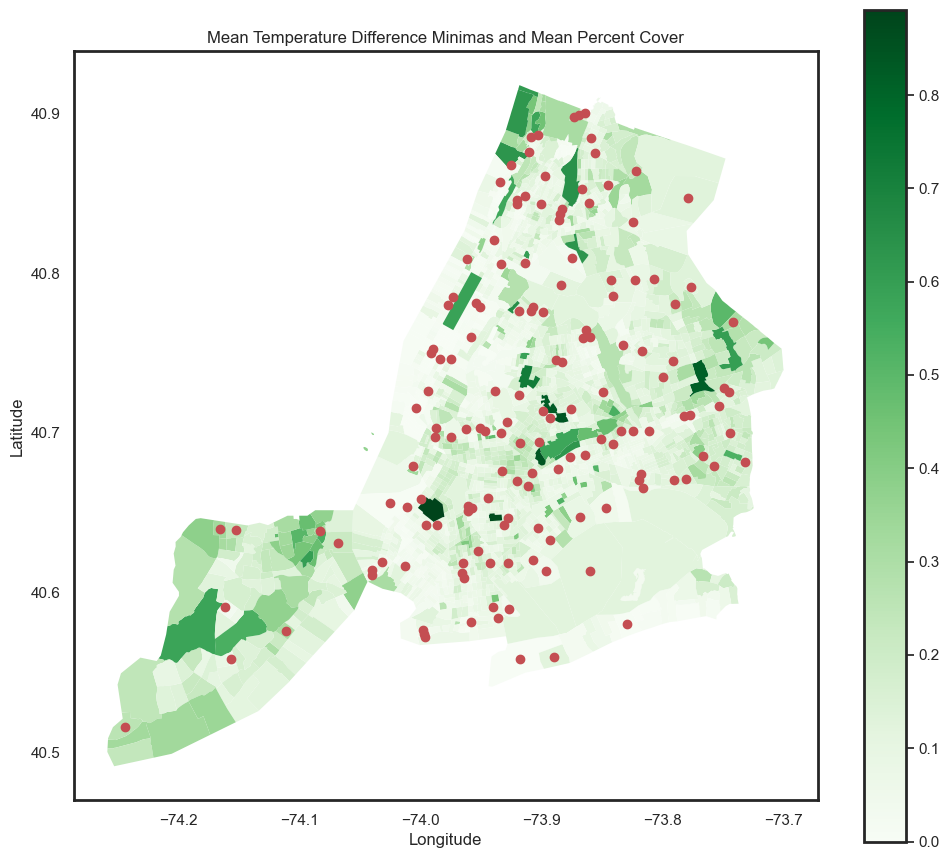

In [40]:
minima_cols = merged[['GEOID', 'minima_aqi', 'minima_temp', 'minima_diff', 'water_gaussian', 'green_gaussian', 'geometry', 'latitude', 'longitude', 'mean_percent_tree_cover', 'water_percentage']]
minima_cols.describe()
minima_cols = gpd.GeoDataFrame(minima_cols)

aqimn = minima_cols[minima_cols['minima_diff'] == 1]
fig, ax=plt.subplots(figsize=(12,12))

minima_cols.plot(ax = ax, column='mean_percent_tree_cover', cmap='Greens', legend=True, edgecolor = 'none', legend_kwds={'shrink': 0.9})
ax.scatter(aqimn.latitude, aqimn.longitude, c = 'r')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_title(r'Mean Temperature Difference Minimas and Mean Percent Cover')
plt.savefig('./minimas/diff_green.png', bbox_inches='tight')
plt.show()



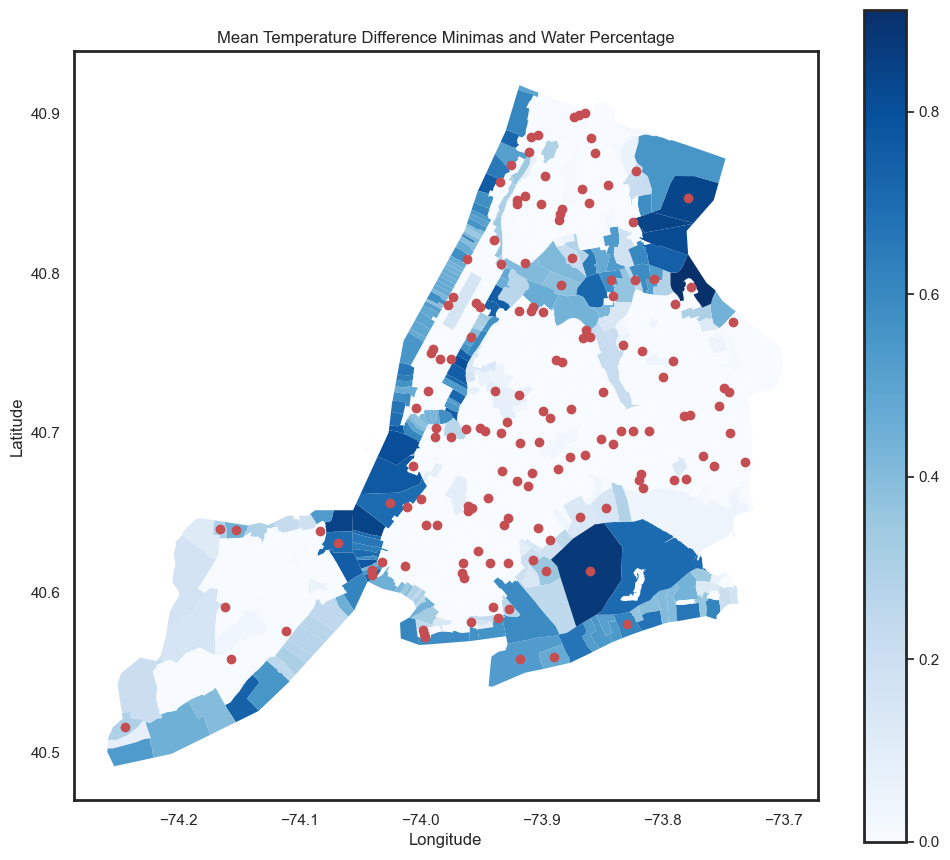

In [41]:
minima_cols = merged[['GEOID', 'minima_aqi', 'minima_temp', 'minima_diff', 'water_gaussian', 'green_gaussian', 'geometry', 'latitude', 'longitude', 'mean_percent_tree_cover', 'water_percentage']]
minima_cols.describe()
minima_cols = gpd.GeoDataFrame(minima_cols)

aqimn = minima_cols[minima_cols['minima_diff'] == 1]
fig, ax=plt.subplots(figsize=(12,12))

minima_cols.plot(ax = ax, column='water_percentage', cmap='Blues', legend=True, edgecolor = 'none', legend_kwds={'shrink': 0.9})
ax.scatter(aqimn.latitude, aqimn.longitude, c = 'r')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_title(r'Mean Temperature Difference Minimas and Water Percentage')
plt.savefig('./minimas/diff_blue.png', bbox_inches='tight')
plt.show()

In [43]:
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
tree_nyc = awater_df

formula = 'surface_temp ~ water_gaussian * green_gaussian'
params = ['surface_temp', 'diff1', 'diff2', 'air_impurity']
for param in params:
    formula = param + ' ~ water_gaussian * green_gaussian'
    avg_train_r2 = 0
    avg_test_r2 = 0
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(tree_nyc):
        train = tree_nyc.iloc[train_index]
        test = tree_nyc.iloc[test_index]
        model = OLS.from_formula(formula, data=train)
        result = model.fit()
        preds = result.predict(test)
        train_r2 = result.rsquared
        test_r2 = r2_score(test[param], (preds))
        avg_train_r2 += train_r2
        avg_test_r2 += test_r2
    print(param, ' & ', round(avg_train_r2 / 5, 3), ' & ', round(avg_test_r2 / 5, 3), ' \\\\ ')

surface_temp  &  0.237  &  0.233  \\ 
diff1  &  0.233  &  0.229  \\ 
diff2  &  0.246  &  0.243  \\ 
air_impurity  &  0.412  &  0.408  \\ 
